<a href="https://colab.research.google.com/github/ThomasAlbin/Space-Tools/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf

from tensorflow import keras

In [2]:
# Create a Sampling Layer
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# Building the encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = keras.layers.Conv2D(filters=32,
                        kernel_size=3,
                        activation="relu",
                        strides=2,
                        padding="same")(encoder_inputs)
x = keras.layers.Conv2D(filters=32,
                        kernel_size=3,
                        activation="relu",
                        strides=2,
                        padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=16,
                       activation="relu")(x)

z_mean = keras.layers.Dense(latent_dim,
                            name="z_mean")(x)
z_log_var = keras.layers.Dense(latent_dim,
                               name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs,
                      [z_mean, z_log_var, z],
                      name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 32)     9248        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1568)         0           ['conv2d_1[0][0]']               
                                                                                            

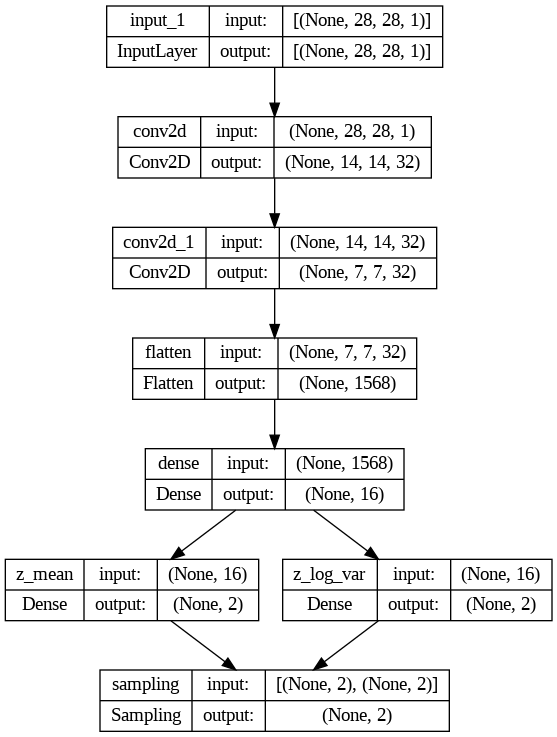

In [4]:
# Visualization
# From: https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(encoder,
           show_shapes=True,
           show_layer_names=True)

In [5]:
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))

x = keras.layers.Dense(units=7 * 7 * 64,
                       activation="relu")(latent_inputs)
x = keras.layers.Reshape(target_shape=(7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(filters=64,
                                 kernel_size=3,
                                 activation="relu",
                                 strides=2,
                                 padding="same")(x)
x = keras.layers.Conv2DTranspose(filters=32,
                                 kernel_size=3,
                                 activation="relu",
                                 strides=2,
                                 padding="same")(x)
decoder_outputs = keras.layers.Conv2DTranspose(filters=1,
                                               kernel_size=3,
                                               activation="sigmoid",
                                               padding="same")(x)
decoder = keras.Model(latent_inputs,
                      decoder_outputs,
                      name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

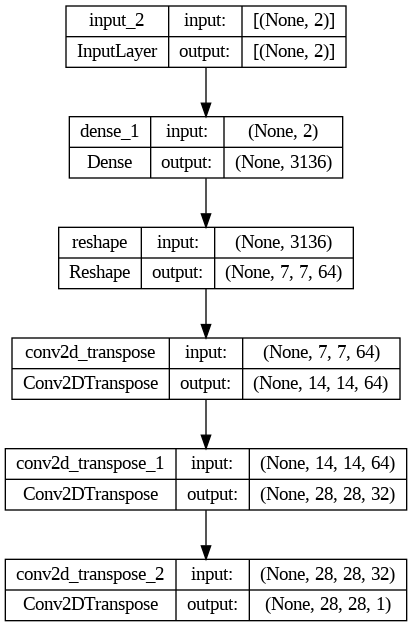

In [6]:
plot_model(decoder,
           show_shapes=True,
           show_layer_names=True)

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

In [ ]:
# Train the VAE
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 91s 163ms/step - loss: 256.7201 - reconstruction_loss: 207.7558 - kl_loss: 2.7475
Epoch 2/30
547/547 [==============================] - 88s 160ms/step - loss: 174.1720 - reconstruction_loss: 165.1889 - kl_loss: 5.4151
Epoch 3/30
547/547 [==============================] - 69s 127ms/step - loss: 164.0302 - reconstruction_loss: 157.5818 - kl_loss: 5.4231
Epoch 4/30
547/547 [==============================] - 69s 127ms/step - loss: 160.7484 - reconstruction_loss: 154.7403 - kl_loss: 5.4625
Epoch 5/30
547/547 [==============================] - 69s 126ms/step - loss: 158.8319 - reconstruction_loss: 152.8792 - kl_loss: 5.5361
Epoch 6/30
547/547 [==============================] - 69s 126ms/step - loss: 157.5891 - reconstruction_loss: 151.7913 - kl_loss: 5.5997
Epoch 7/30
547/547 [==============================] - 69s 126ms/step - loss: 156.6010 - reconstruction_loss: 150.8422 - kl_loss: 5.6547
Epoch 8/30
547/547 [============================

In [ ]:
# Display a grid of sampled digits
from matplotlib import pyplot as plt

def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1
    figure = np.zeros((digit_size * n,
                       digit_size * n))
    
    # Linearly spaces coordiantes corresponding to the 2D plot of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded =vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))

    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.imshow(figure, cmap="Greys_r")

    plt.show()

plot_latent_space(vae)

In [ ]:
# Display how the latent space clustern different digit classes
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)

    plt.figure(figsize=(12, 10))

    plt.scatter(z_mean[:, 0],
                z_mean[:, 1],
                c=labels)
    
    plt.colorbar()

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)